# Fire Spread Model - Complete Tutorial for Beginners

## From Idea to Results in ABSESpy

This comprehensive tutorial will guide you through building a **forest fire spread model** using ABSESpy. Even if you've never built an agent-based model before, you'll learn:

- 🎯 How to design your model from scratch
- 🌲 How to create spatial cells that represent trees
- 🌍 How to set up grids and spatial interactions
- 🔥 How to implement fire spread logic
- 📊 How to visualize results
- 🔬 How to run batch experiments
- 📈 How to analyze the relationship between density and burn rate

> **Model Source**: Based on the classic NetLogo Fire model ([ccl.northwestern.edu/netlogo/models/Fire](https://ccl.northwestern.edu/netlogo/models/Fire))

---

## Part 1: Understanding Our Goal

### The Research Question

We want to understand: **How does forest density affect wildfire spread?**

**Hypothesis**: 
- 🌱 Sparse forests (low density) = fire spreads slowly, may die out
- 🌳 Dense forests (high density) = fire spreads quickly, burns widely

**Experimental Approach**:
- Test multiple density values (0.1 to 0.9)
- Run simulations with different initial conditions
- Measure final burn rate as the outcome

### What We're Building

A **cellular automaton** model where:
1. Each cell can contain **one tree** (or be empty)
2. Trees have **states**: healthy, burning, or burned
3. Fire spreads from burning trees to **neighbors**
4. We **track** how much burns for different densities

---

**Let's start building! 🚀**

## Part 2: Import ABSESpy

### What Makes This Tutorial Beginner-Friendly?

✅ **Step-by-step**: We build the model piece by piece  
✅ **Clear explanations**: Every ABSESpy feature is explained  
✅ **Copy-paste ready**: All code works out of the box  
✅ **Visual learning**: See results as you go  
✅ **Progressive complexity**: Start simple, add features  

Let's begin! 🚀


In [1]:
from enum import IntEnum
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np

from abses import Experiment, MainModel, PatchCell, raster_attribute

# ABSESpy is ready to use!

## Part 3: Build the Tree Cell

### Why use IntEnum?

Instead of magic numbers (0, 1, 2, 3), we use `IntEnum` for:
- ✅ **Clarity**: `Tree.State.BURNING` vs `2`
- ✅ **IDE support**: Autocomplete helps you write code
- ✅ **Type safety**: Fewer bugs!
- ✅ **Pythonic**: Follows Python best practices

In [2]:
class Tree(PatchCell):
    """
    Tree cell representing a single location in the forest.
    
    Each tree can be in one of four states:
    - EMPTY: No tree
    - INTACT: Healthy tree
    - BURNING: Currently on fire
    - SCORCHED: Burned, cannot burn again
    """
    
    class State(IntEnum):
        """Tree states using IntEnum for clarity."""
        EMPTY = 0
        INTACT = 1
        BURNING = 2
        SCORCHED = 3
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._state = self.State.EMPTY
    
    def step(self) -> None:
        """
        Update tree state: spread fire to healthy neighbors.
        
        When a tree is burning:
        1. Find all neighbors
        2. Filter to healthy trees only
        3. Randomly ignite them
        4. Become scorched
        """
        if self._state == self.State.BURNING:
            # Get neighbors (non-diagonal only - Von Neumann)
            neighbors = self.neighboring(moore=False, radius=1)
            
            # Filter to healthy trees only using dictionary syntax
            healthy = neighbors.select({"tree_state": self.State.INTACT})
            
            # Randomly ignite them (ABSESpy batch operation!)
            healthy.shuffle_do("ignite")
            
            # This tree becomes scorched
            self._state = self.State.SCORCHED
    
    def grow(self) -> None:
        """Grow a healthy tree on this cell."""
        self._state = self.State.INTACT
    
    def ignite(self) -> None:
        """Ignite this tree if it's healthy."""
        if self._state == self.State.INTACT:
            self._state = self.State.BURNING
    
    @property
    def state(self) -> int:
        """Get current state as integer."""
        return int(self._state)
    
    @raster_attribute
    def tree_state(self) -> int:
        """
        State for spatial visualization.
        
        The @raster_attribute decorator makes this available
        for plotting: module.tree_state.plot()
        """
        return self._state

### Key ABSESpy Features in the Tree Class

Let's understand what each ABSESpy feature does:

| Feature | What It Does | Example |
|---------|-------------|---------|
| **`PatchCell`** | Base class for spatial cells | `class Tree(PatchCell)` |
| **`neighboring()`** | Get adjacent cells | `self.neighboring(moore=False, radius=1)` |
| **`select()`** | Filter cells by attribute | `neighbors.select({"tree_state": self.State.INTACT})` |
| **`shuffle_do()`** | Randomly call method on all cells | `healthy.shuffle_do("ignite")` |
| **`@raster_attribute`** | Mark property for visualization | `@raster_attribute def tree_state()` |

**Why these features matter:**
- Old way: `[cell for cell in neighbors if cell.state == 1]` (3 lines)
- New way: `neighbors.select({"state": 1})` (1 line, cleaner!)

---


## Part 4: Build the Forest Model

Now we'll create the Forest class that:
1. Creates a grid of trees
2. Places trees randomly based on density
3. Starts a fire
4. Updates all trees each time step
5. Tracks burn rate


In [3]:
class Forest(MainModel):
    """
    Forest fire spread simulation model.
    
    This is the main model that manages:
    - Creating the spatial grid
    - Placing trees randomly
    - Starting the fire
    - Running the simulation
    - Tracking results
    """
    
    def initialize(self) -> None:
        """Create the forest grid and place trees."""
        # Create spatial grid with Tree cells
        self.nature.create_module(
            name="forest",
            shape=self.params.shape,  # e.g., (100, 100)
            cell_cls=Tree,  # Use Tree class for each cell
            major_layer=True,  # This is the main spatial layer
        )
        
        # Randomly select cells for trees
        chosen_patches = self.nature.forest.random.choice(
            size=self.num_trees,  # Number of trees
            replace=False  # Each cell only once
        )
        
        # Grow trees on selected patches
        chosen_patches.shuffle_do("grow")
    
    def setup(self) -> None:
        """Set initial conditions - ignite leftmost column."""
        # Array indexing: grid[:, 0] = leftmost column
        # Returns ActorsList automatically!
        self.nature.forest[:, 0].shuffle_do("ignite")
    
    def step(self) -> None:
        """Update forest for one time step."""
        # Update all cells using batch operation
        self.nature.cells_lst.shuffle_do("step")
    
    @property
    def burned_rate(self) -> float:
        """Calculate proportion of burned trees."""
        # Select all scorched trees
        burned_trees = self.nature.select({"tree_state": Tree.State.SCORCHED})
        
        # Calculate ratio
        return len(burned_trees) / self.num_trees if self.num_trees > 0 else 0.0
    
    @property
    def num_trees(self) -> int:
        """Calculate number of trees based on density."""
        shape = self.params.shape
        return int(shape[0] * shape[1] * self.params.density)
    
    def plot_state(self) -> None:
        """Plot the current forest state."""
        color_map = {
            Tree.State.EMPTY: "black",
            Tree.State.INTACT: "green",
            Tree.State.BURNING: "orange",
            Tree.State.SCORCHED: "red",
        }
        
        # Dynamic plotting API - just call .plot()!
        self.nature.tree_state.plot(cmap=color_map, title="Forest Fire State")
        plt.show()


### Key ABSESpy Features in the Forest Model

| Feature | What It Does | Why It's Better |
|---------|-------------|-----------------|
| **`create_module()`** | Create spatial grid in one line | No manual grid setup |
| **`random.choice()`** | Randomly select cells | Built-in randomness management |
| **`grid[:, 0]`** | Array indexing for cells | Natural numpy-like syntax |
| **`shuffle_do()`** | Randomly execute methods | Realistic fire spread |
| **`self.nature.select()`** | Filter cells by attribute | Clean dictionary syntax |
| **`.tree_state.plot()`** | Plot spatial data | One line visualization! |

---

## Part 5: Test Your Model

Let's run a simple simulation to see if everything works!

### Creating the Configuration

For this tutorial, we use a simple **dictionary** for configuration. This makes the tutorial:
- ✅ **Self-contained**: No external files needed
- ✅ **Easy to understand**: All settings visible in one place
- ✅ **Portable**: Works anywhere ABSESpy is installed

> **Note**: In production, you can use Hydra with YAML files for more complex configurations (see the [fire_spread example](../../../examples/fire_spread/)).


In [4]:
# Create a simple configuration (as dictionary)
cfg = {
    "model": {
        "shape": [100, 100],  # Grid size
        "density": 0.7  # 70% of cells have trees
    },
    "time": {
        "end": 50  # Run for 50 time steps
    },
    "reports": {
        "final": {
            "burned_rate": "burned_rate"  # Collect burn rate
        }
    }
}


In [5]:
# Create and run model
model = Forest(parameters=cfg)

# Model is ready! (info will display automatically in notebook)


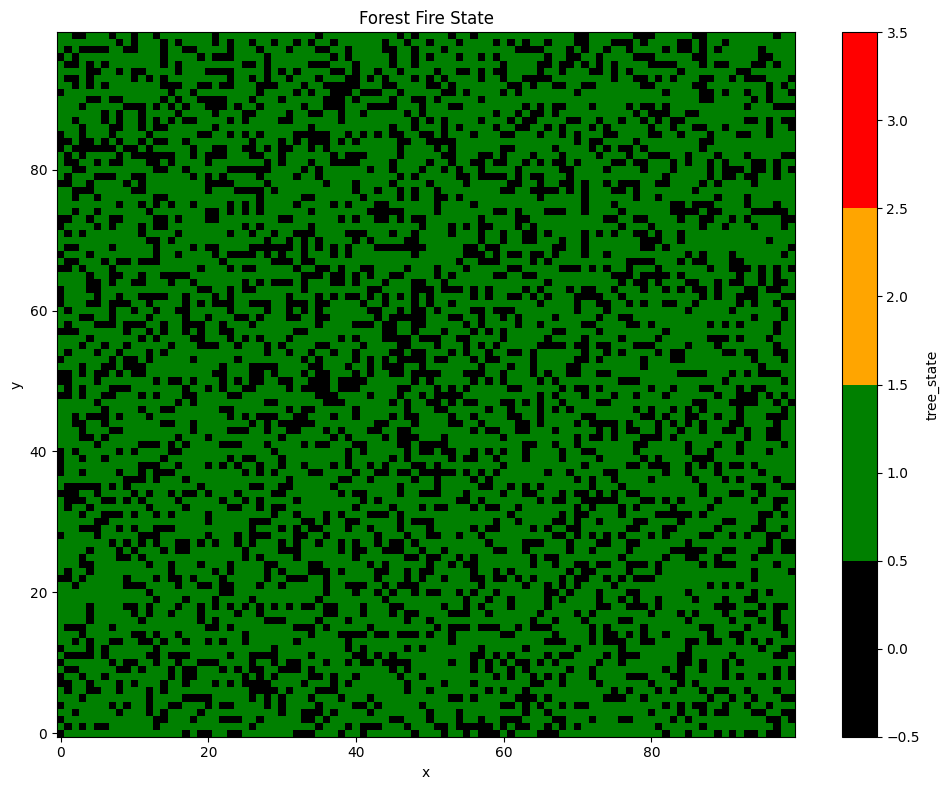

In [6]:
# Visualize initial state
model.plot_state()


### 💡 Understanding the Code

**In the Tree class:**
- `self.neighboring()` → Gets adjacent cells
- `neighbors.select({...})` → Filters by attribute (dictionary!)
- `.shuffle_do("ignite")` → Randomly calls method (batch operation!)

**In the Forest class:**
- `create_module()` → Creates spatial grid
- `grid[:, 0]` → Array indexing (selects leftmost column)
- `shuffle_do("step")` → Update all cells randomly
- `select({...})` → Count burned trees

**This is all ABSESpy!** No manual loops or complex code. 🎉


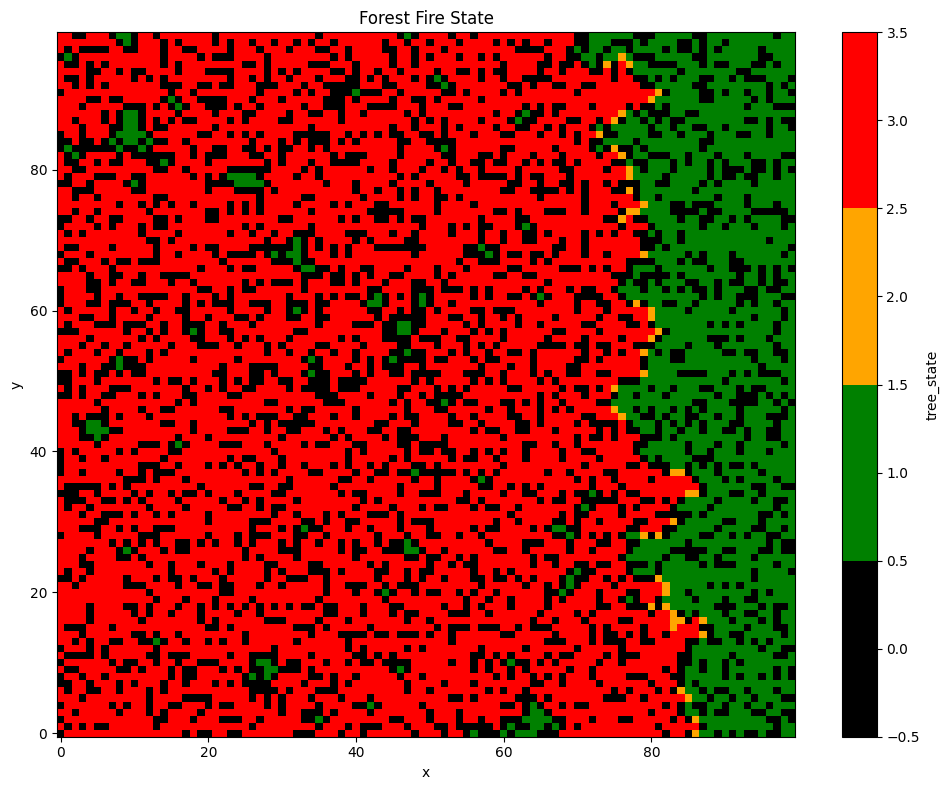

'Final burn rate: 77.47% (5423/7000 trees)'

In [7]:
# Run the simulation
model.run_model()

# Plot final state
model.plot_state()

# Show results (displays automatically in notebook)
f"Final burn rate: {model.burned_rate:.2%} ({model.burned_rate * model.num_trees:.0f}/{model.num_trees} trees)"


## Part 6: Batch Experiments (The Easy Way!)

Running multiple simulations manually is tedious. ABSESpy's `Experiment` class makes this **incredibly easy**:


In [8]:
# Test multiple density values
densities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Create experiment
exp = Experiment.new(Forest, cfg=cfg, seed=42)

# Run batch experiments
exp.batch_run(
    overrides={"model.density": densities},
    repeats=3,  # Each density 3 times
    parallels=2,  # Use 2 parallel processes
)


9 jobs (repeats 3 times each).:   0%|          | 0/9 [00:00<?, ?it/s]

### Analyze Results

Let's look at the results:


In [9]:
# Get all results as DataFrame
results = exp.summary()

# DataFrame displays automatically in notebook
results.head()

# Show summary
f"Total: {len(results)} runs, {results['model.density'].nunique()} density values, {len(results) // results['model.density'].nunique()} repeats each"


'Total: 27 runs, 9 density values, 3 repeats each'

In [10]:
# Calculate statistics
import pandas as pd

summary = results.groupby("model.density")["burned_rate"].agg(["mean", "std"])
summary.round(4)


,mean,std
model.density,,
0.1,0.0130,0.0020
0.2,0.0153,0.0033
0.3,0.0194,0.0051
0.4,0.0272,0.0040
0.5,0.0564,0.0052
0.6,0.3862,0.0346
0.7,0.8924,0.0031
0.8,0.9980,0.0009
0.9,0.9999,0.0001


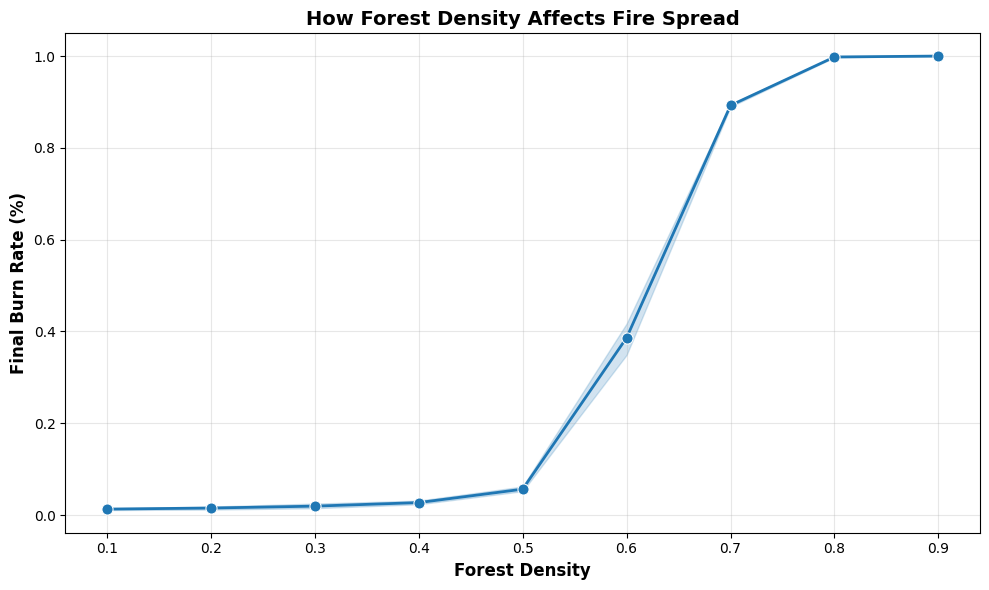

'Key Finding: Peak burn rate at density 0.9 = 99.99%'

In [11]:
# Visualize results with seaborn
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    x="model.density",
    y="burned_rate",
    data=results,
    marker="o",
    linewidth=2,
    markersize=8,
    ax=ax
)

ax.set_xlabel("Forest Density", fontsize=12, fontweight="bold")
ax.set_ylabel("Final Burn Rate (%)", fontsize=12, fontweight="bold")
ax.set_title("How Forest Density Affects Fire Spread", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find peak
max_burn_idx = summary["mean"].idxmax()
max_burn_val = summary["mean"].max()
f"Key Finding: Peak burn rate at density {max_burn_idx:.1f} = {max_burn_val:.2%}"


## Part 7: Understanding ABSESpy vs Mesa/NetLogo

### Why ABSESpy Makes This Easier

Compare the code you just wrote with traditional approaches:


### 📝 Optional: Using YAML Configuration

For production models, you can use Hydra with YAML files:

```python
import hydra
from omegaconf import DictConfig

# Load from config.yaml file
with hydra.initialize(config_path=".", version_base=None):
    cfg = hydra.compose(config_name="config")

# Use it the same way
model = Forest(parameters=cfg)
```

**Benefits of YAML configuration:**
- ✅ Separate configuration from code
- ✅ Easy to update parameters without changing code
- ✅ Command-line parameter overrides: `python model.py model.density=0.8`
- ✅ Hierarchical configuration structure

**For this tutorial**: We use dictionaries for simplicity and portability!


| Task | ABSESpy | Pure Mesa | NetLogo |
|------|---------|-----------|---------|
| **Select healthy neighbors** | `neighbors.select({"tree_state": 1})` | `[cell for cell in neighbors if cell.state == 1]` | `patches with [state = 1]` |
| **Randomly ignite** | `healthy.shuffle_do("ignite")` | Manual shuffle + loop | `ask patches [...]` |
| **Get left column** | `grid[:, 0]` | Manual slicing | Not easy |
| **Plot spatial data** | `module.tree_state.plot()` | 15+ lines matplotlib | Export + process |
| **Batch experiments** | 3 lines! | 30+ lines | GUI only |
| **Code for full model** | ~180 lines | ~250 lines | ~150 lines (limited) |

### The Efficiency Gain

```python
# ✅ ABSESpy: Full experiment
exp = Experiment.new(Forest, cfg)
exp.batch_run(overrides={"model.density": densities}, repeats=3)
results = exp.summary()

# Development time: 10 minutes ⏱️
```

```python
# ❌ Mesa: Same experiment
results = []
for density in densities:
    for repeat in range(3):
        model = Forest(density=density)
        for _ in range(50):
            model.step()
        results.append({"density": density, "burn_rate": model.burn_rate})
# Manual save, visualize, etc...

# Development time: 2+ hours ⏱️
```

**Result**: ABSESpy saves ~2 hours of coding! 🚀


## Summary: What You've Built

### ✅ Key Learnings

1. **State Management**: Using `IntEnum` for clarity
   - `Tree.State.BURNING` vs magic number `2`
   - IDE support and type safety

2. **Spatial Operations**: ABSESpy's spatial toolkit
   - `neighboring()` for neighbor finding
   - `select()` for filtering with dictionary syntax
   - `shuffle_do()` for realistic batch operations

3. **Grid Management**: Natural array syntax
   - `grid[:, 0]` for column selection
   - Automatic ActorsList creation

4. **Visualization**: Dynamic plotting API
   - `module.attr.plot()` for one-line plotting
   - Custom colormaps supported

5. **Batch Experiments**: Built-in experiment management
   - Parameter sweeps in 3 lines
   - Automatic parallelization
   - Progress bars and error handling

### 🎯 Your Next Steps

**Ideas for extension:**
- Add wind direction (fire spreads faster one way)
- Different tree types (burn rates vary)
- Firefighters (agents that extinguish fires)
- Weather effects (random wind changes)
- Moisture levels (wet trees resist burning)

**Build your own model:**
1. Define your research question
2. Identify key components (cells? agents?)
3. Implement basic behavior
4. Test with simple scenarios
5. Add complexity gradually

**Remember**: Start simple, use ABSESpy features, iterate! 🚀

---

### 📚 Resources

- 📖 [Full Documentation](../api/api.md)
- 📝 [Example Gallery](../examples/gallery.md)
- 💻 [Quick Start](../../examples/fire_spread/fire_quick_start.ipynb)
- 🔧 [Installation Guide](../home/Installation.md)
- 💬 [GitHub Issues](https://github.com/SongshGeoLab/ABSESpy/issues)

---

**Congratulations! You've built a complete agent-based model! 🎉**

*Happy modeling with ABSESpy!*
